In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/AIP

/content/drive/MyDrive/AIP


# Import Library

In [ ]:
import os
import os.path
import requests

from scipy.integrate import odeint
import torch
from torch import nn, optim
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler, StandardScaler


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',font_scale=0.6)
rcParams['figure.figsize'] = 6,4
register_matplotlib_converters()

# Dowload Data

In [ ]:
# DATA
URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
CONFIRMED="time_series_covid19_confirmed_global.csv" 
DEATH="time_series_covid19_deaths_global.csv"
RECOVERED="time_series_covid19_recovered_global.csv"

In [ ]:
# Fixed random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
# Download dataset from GitHub which was provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).
if not os.path.isfile(f"./dataset/{CONFIRMED}"):
    for name in [CONFIRMED, DEATH, RECOVERED]:
        url = os.path.join(URL, name)
        r = requests.get(url)
        file_csv = open(os.path.join("./dataset", name), 'wb')
        file_csv.write(r.content)
        file_csv.close()        

In [ ]:
TEST_SIZE = 14

# SEIR

In [ ]:
# Set constant values
def set_seir(reproductive_number = 2):
    ## Total of population the world; scr: https://www.worldometers.info/world-population/
    population = 7768726098
    rate_of_brith = 1.05
    print(u"population of the world is {}.".format(population))

    ## recovery rate is the mean of recovered and death cases of the total cases
    _death = pd.read_csv(os.path.join("dataset",DEATH)).iloc[:, 4:280].sum(axis=0)
    _death = _death.diff().fillna(_death[0]).astype(np.int64)
    _recovery = pd.read_csv(os.path.join("dataset",RECOVERED)).iloc[:, 4:280].sum(axis=0)
    _recovery = _recovery.diff().fillna(_recovery[0]).astype(np.int64)
    _recovery_and_death = _death + _recovery
    _recovery_and_death = _recovery_and_death.pct_change().fillna("0").astype(np.int64)
    rate_of_recover_and_death = _recovery_and_death.mean()
    print(u"recovery rate is {}.".format(rate_of_recover_and_death))

    ## incubation rate is the mean of confirmed cases of the total cases
    _confirmed = pd.read_csv(os.path.join("dataset",CONFIRMED)).iloc[:, 4:280].sum(axis=0)
    _confirmed = _confirmed.diff().fillna(_confirmed[0]).astype(np.int64)
    _confirmed = _confirmed.pct_change().fillna("0").astype(np.int64)
    rate_of_incubation = _confirmed.mean()
    print(u"incubation rate is {}.".format(rate_of_incubation))

    ## contact rate will calculated by assume that R_0 = 2 then contact rate = R_0 * reconvery rate
    rate_of_contactive =  reproductive_number * rate_of_recover_and_death
    print(u"contact rate is {}.".format(rate_of_contactive))
    return population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death

def seir_model(day_zero = -1):
    ''' SEIR model without vital dynamics '''
    # Total population, N; 
    N = population
    # Initial number of infected, exposed and recovered individuals, I0, E0 and R0.
    ## Initial rnumber of recovered cases is the number of recovered plus death cases in the lastest day in the time series 
    ### day_zero = -1 means use the lastest day in the time-series as day 0 of epidemic
    R0 = pd.read_csv(os.path.join("dataset",DEATH)).iloc[:, 280-day_zero].sum(axis=0).astype(np.int64) +\
            pd.read_csv(os.path.join("dataset",RECOVERED)).iloc[:, 280-day_zero].sum(axis=0).astype(np.int64)
    ## Initial rnumber of infected cases is confirmed minus death and recovered cases in lastest day in the time series 
    I0 = pd.read_csv(os.path.join("dataset",CONFIRMED)).iloc[:, 280-day_zero].sum(axis=0).astype(np.int64) - R0
    ## assume that confirmed cases is nothing but merely the tip of the iceberg; therefore, let confirmed infected group is ten percent of exposed group.
    E0 = 7 * I0 
    S0 = N - I0 - R0 - E0
    print(u"Initial number of infected, exposed and recovered individuals are {}, {}, and {} respectively.".format(I0, E0, R0))
    print(u"Now, the initial number of susceptible individuals is {}.".format(S0))

    # Average contact rate(beta), incubation rate(alpha) and recovery rate(gamma) (in 1/days); 
    beta = rate_of_contactive
    alpha = rate_of_incubation
    gamma = rate_of_recover_and_death

    # A grid of time points (in days)
    DAYS_TO_PREDICT = 300
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)

    # The SIR model differential equations.
    def deriv(y, t, N, alpha, beta, gamma):
        S, E, I, R = y
        dSdt = -beta * S * I / N
        dEdt = beta * S *  I / N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, alpha, beta, gamma))
    S, E, I, R = ret.T

    # Plot the data on three separate curves for S(t), I(t) and R(t)
    plt.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
    plt.plot(t, E/1000000, 'y', alpha=0.5, lw=2, label='Exposed')
    plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
    plt.plot(t, R/1000000, 'g', alpha=0.5, lw=2, label='Recovered with immunity or Death')
    plt.xlabel('days from 10/23/2020')
    plt.ylabel('Number (millions)')
    plt.grid(b=True, which='major', c='w', lw=2, ls='-')
    plt.legend()
    plt.title("SEIR model")
    plt.savefig("seir_model.jpg")
    plt.show()
    plt.close()

    ## from now on model
    if day_zero != -TEST_SIZE:
        plt.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel('days from 10/23/2020')
        plt.ylabel('Number (millions)')
        plt.legend()
        plt.title("SEIR model for prediction infected cases (future)")
        plt.savefig("future_seir_model.jpg")
        plt.show()
        plt.close()

    else:
        total_confirmed = cases(csv=CONFIRMED, name="confirmed")[-TEST_SIZE:]
        total_death = cases(csv=DEATH, name="deaths")[-TEST_SIZE:]
        total_recovered = cases(csv=RECOVERED, name="recovered")[-TEST_SIZE:]
        real_I = total_confirmed - total_death - total_recovered
        plt.plot(real_I.index[:TEST_SIZE], real_I/1000000, 'r', alpha=0.5, lw=2, label='Real Infected cases')
        plt.plot(real_I.index[:TEST_SIZE], I[:TEST_SIZE]/1000000, 'b', alpha=0.5, lw=2, label='Predicted Infected cases')
        plt.xlabel(u'{} days ago to 10/23/2020'.format(TEST_SIZE))
        plt.ylabel('Number (millions)')
        plt.title("SEIR model for prediction infected cases (validation)")
        plt.xticks(rotation=90)
        plt.legend()
        plt.tight_layout()
        plt.savefig("validation_seir_model.jpg")
        plt.show()
        plt.close()


# Preprocessing

In [ ]:
def cases(csv, name):
    # load dataset
    df = pd.read_csv(os.path.join("dataset",csv))
    #print(df.head())

    # select only time series parts
    df = df.iloc[:, 4:280]

    # check missing values
    if df.isnull().sum().sum():
        print("There are missing values, do some thing with them.")

    # get number of cases of the day
    cases = df.sum(axis=0)
    
    # show graph of confirmed cases
    plt.plot(cases)
    plt.title(name+" cases")
    plt.xticks(rotation=45)
    plt.savefig(name+"_cases.jpg")
    #plt.show()
    plt.close()

    # get only number of new cases of the day
    daily_cases = cases.diff().fillna(cases[0]).astype(np.int64)

    # show graph of daily confirmed cases
    plt.plot(daily_cases)
    plt.title("daily "+name+" cases")
    plt.xticks(rotation=45)
    plt.savefig("daily_"+name+"_cases.jpg")
    #plt.show()
    plt.close()

    # show graph of daily and total of the day
    plt.plot(cases, label="Total cases")
    plt.plot(daily_cases, label="Daily cases")
    plt.title("Daily and total "+name+" cases")
    plt.xticks(rotation=45)
    plt.legend()
    plt.savefig("daily_total_"+name+"_cases.jpg")
    #plt.show()
    plt.close()
    
    return cases

# LSTM

In [ ]:
def build_lstm(time_series_data, name):
    print(u"Building LSTM model for {} group.".format(name))
    ''' Long-short Term Memory network '''
    train = time_series_data[:-TEST_SIZE]
    test = time_series_data[-TEST_SIZE:]

    # preprocessing data
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(train, axis=1))
    train = scaler.transform(np.expand_dims(train, axis=1))
    test = scaler.transform(np.expand_dims(test, axis=1))

    def create_sequences(data, seq_length):
        xs = []
        ys = []

        for i in range(len(data)-seq_length-1):
            x = data[i:(i+seq_length)]
            y = data[i+seq_length]
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    # data preparing
    seq_length = 5
    X_train, y_train = create_sequences(train, seq_length)
    X_test, y_test = create_sequences(test, seq_length)

    X_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()

    X_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()

    # model training
    class CoronaVirusPredictor(nn.Module):

        def __init__(self, n_features, n_hidden, seq_len, n_layers=4):
            super(CoronaVirusPredictor, self).__init__()

            self.n_hidden = n_hidden
            self.seq_len = seq_len
            self.n_layers = n_layers

            self.lstm = nn.LSTM(
                        input_size=n_features,
                        hidden_size=n_hidden,
                        num_layers=n_layers,
                        dropout=0.2
                        )

            self.linear = nn.Linear(in_features=n_hidden, out_features=1)

        def reset_hidden_state(self):
            self.hidden = (
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
                            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
                        )

        def forward(self, sequences):
            lstm_out, self.hidden = self.lstm(
                                    sequences.view(len(sequences), self.seq_len, -1),
                                    self.hidden
                                    )

            last_time_step = \
                lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]

            y_pred = self.linear(last_time_step)
            return y_pred

    
    ## define training method
    def train_model(model, train, train_labels, test_data=None, test_labels=None):
        loss_fn = torch.nn.MSELoss()

        optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
        num_epochs = 200

        train_hist = np.zeros(num_epochs)
        test_hist = np.zeros(num_epochs)

        for t in range(num_epochs):
            model.reset_hidden_state()

            y_pred = model(X_train)

            loss = loss_fn(y_pred.float(), y_train)

            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(X_test)
                    test_loss = loss_fn(y_test_pred.float(), y_test)

                test_hist[t] = test_loss.item()

                if t % 20 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

            elif t % 20 == 0:
                print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()
            
            optimiser.zero_grad()

            loss.backward()

            optimiser.step()
        
        return model.eval(), train_hist, test_hist

    ## building step here
    model = CoronaVirusPredictor(n_features=1, n_hidden=128, seq_len=seq_length, n_layers=4)
    model, train_hist, test_hist = train_model(model, X_train, y_train, X_test, y_test)
    
    plt.title("Training process "+ name+" cases")
    plt.plot(train_hist, label="Training loss")
    plt.plot(test_hist, label="Test loss")
    plt.legend();
    plt.show()
    plt.close()
    
    # prediction step
    def predict(data_seq, predict_len):
        seq = data_seq
        preds = []
        for _ in range(predict_len):
            y_pred = model(seq)
            pred = torch.flatten(y_pred).item()
            preds.append(pred)
            new_seq = seq.numpy().flatten()
            new_seq = np.append(new_seq, [pred])
            new_seq = new_seq[1:]
            seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

        predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()
    
        return predicted_cases
    

    #self_predicted_cases = predict(X_train[:1], TRAIN_SIZE)
    validation_predicted_cases = predict(X_test[:1], TEST_SIZE)
    #validation_predicted_cases = np.append(self_predicted_cases, validation_predicted_cases)
    plt.plot(time_series_data[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_predicted_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millions)')
    plt.xlabel("14 days ago to 10/23/2020")
    plt.title("LSTM model for "+name+" cases")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig(name+"_lstm_model_validation.jpg")
    plt.show()
    plt.close()
    
    scaler = MinMaxScaler()
    scaler = scaler.fit(np.expand_dims(time_series_data, axis=1))
    all_data = scaler.transform(np.expand_dims(time_series_data, axis=1))
    
    X_all, y_all = create_sequences(all_data, seq_length)
    X_all = torch.from_numpy(X_all).float()
    y_all = torch.from_numpy(y_all).float()
    
    model = CoronaVirusPredictor(n_features=1, n_hidden=128, seq_len=seq_length, n_layers=4)
    model, train_hist, _ = train_model(model, X_all, y_all)

    DAYS_TO_PREDICT = 14
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    predicted_cases = predict(X_test[-1:], DAYS_TO_PREDICT)
    plt.plot(t, predicted_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from 10/23/2020")
    plt.ylabel('Number (millions)')
    plt.title("LSTM model for "+name+" cases")
    plt.legend()
    plt.savefig(name+"_lstm_model.jpg")
    plt.show()
    plt.close()

    return validation_predicted_cases, predicted_cases



# Plot data


In [ ]:
def lstm(time_series_data=[], validation_predicted_cases=[], predicted_cases=[]):
    time_series = time_series_data[0] - time_series_data[1] - time_series_data[2]
    validation_cases = validation_predicted_cases[0] - validation_predicted_cases[1] - validation_predicted_cases[2]
    future_cases = predicted_cases[0] - predicted_cases[1] - predicted_cases[2]
    # plot validation graph
    plt.plot(time_series[-TEST_SIZE:]/1000000, label="Real cases")
    plt.plot(validation_cases/1000000, label="Predicted cases")
    plt.ylabel('Number (millions)')
    plt.xlabel("14 days ago to 10/23/2020")
    plt.title("LSTM model for prediction infected cases (validation)")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.savefig("validation_lstm_model.jpg")
    plt.show()
    plt.close()

    # plot prediction graph
    DAYS_TO_PREDICT = 14
    t = np.linspace(0, DAYS_TO_PREDICT, DAYS_TO_PREDICT)
    plt.plot(t, future_cases/1000000, label='Predicted Cases')
    plt.xlabel("days from now")
    plt.ylabel('Number (millions)')
    plt.title("LSTM model for prediction infected cases (future)")
    plt.legend()
    plt.tight_layout()
    plt.savefig("future_lstm_model.jpg")
    plt.show()
    plt.close()


####################################################################################################
population of the world is 7768726098.
recovery rate is 0.07608695652173914.
incubation rate is 0.15579710144927536.
contact rate is 0.15217391304347827.
Initial number of infected, exposed and recovered individuals are 15925824, 111480768, and 34110853 respectively.
Now, the initial number of susceptible individuals is 7607208653.


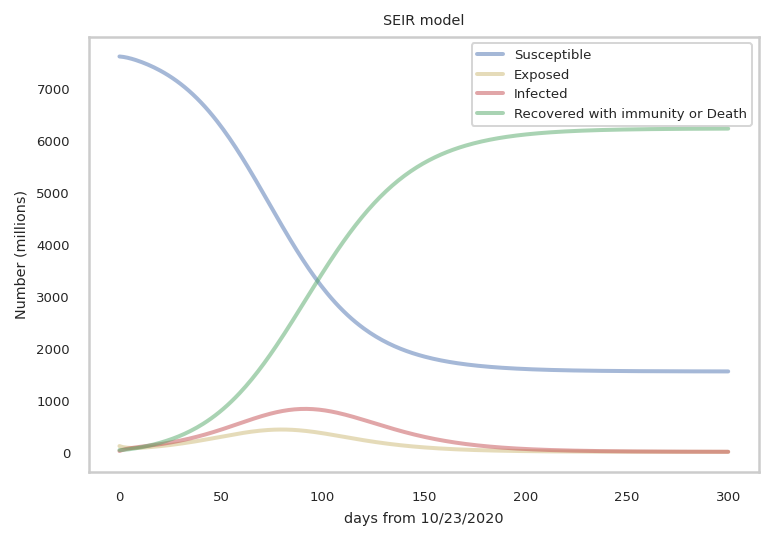

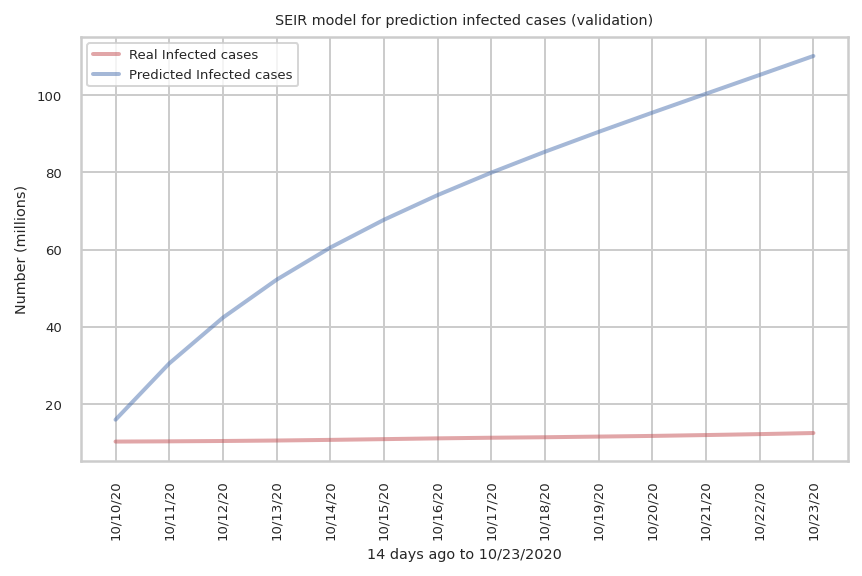

In [ ]:
print("#"*100)
# mathematical model; SEIR model, a compartmental models in epidemiology.
population, rate_of_contactive, rate_of_incubation, rate_of_recover_and_death = set_seir(reproductive_number = 2)
seir_model(day_zero = -TEST_SIZE ) ## model from 14 days ago

In [ ]:
print("#"*100)
# machine learning model; Long-short Term Memory network (as known as LSTM model), a type of recurrent neural network designed model.
total_confirmed = cases(csv=CONFIRMED, name="confirmed")
total_death = cases(csv=DEATH, name="deaths")
total_recovered = cases(csv=RECOVERED, name="recovered")


####################################################################################################


Building LSTM model for confirmed group.
Epoch 0 train loss: 0.1580502986907959 test loss: 1.1315568685531616
Epoch 20 train loss: 0.11283257603645325 test loss: 0.9062111973762512
Epoch 40 train loss: 0.08961457014083862 test loss: 0.5882775187492371
Epoch 60 train loss: 0.08743581175804138 test loss: 0.6326355338096619
Epoch 80 train loss: 0.08601589500904083 test loss: 0.5704865455627441
Epoch 100 train loss: 0.07173313200473785 test loss: 0.349670946598053
Epoch 120 train loss: 0.005341183394193649 test loss: 0.024929756298661232
Epoch 140 train loss: 0.003805452724918723 test loss: 0.03471723571419716
Epoch 160 train loss: 0.003217610064893961 test loss: 0.020956765860319138
Epoch 180 train loss: 0.0017358288168907166 test loss: 0.005161149427294731


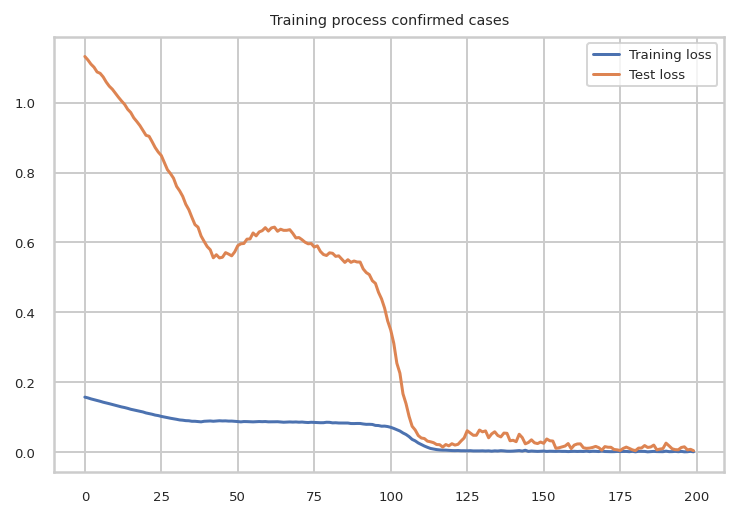

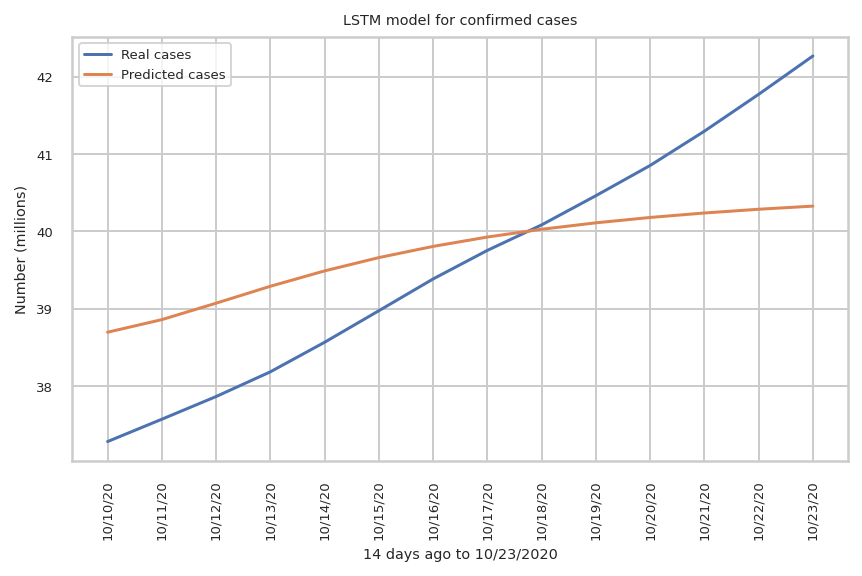

Epoch 0 train loss: 0.25701746344566345
Epoch 20 train loss: 0.19087794423103333
Epoch 40 train loss: 0.1140676811337471
Epoch 60 train loss: 0.08782228082418442
Epoch 80 train loss: 0.08679377287626266
Epoch 100 train loss: 0.08355236798524857
Epoch 120 train loss: 0.07412336766719818
Epoch 140 train loss: 0.007325741462409496
Epoch 160 train loss: 0.0039091347716748714
Epoch 180 train loss: 0.002309301868081093


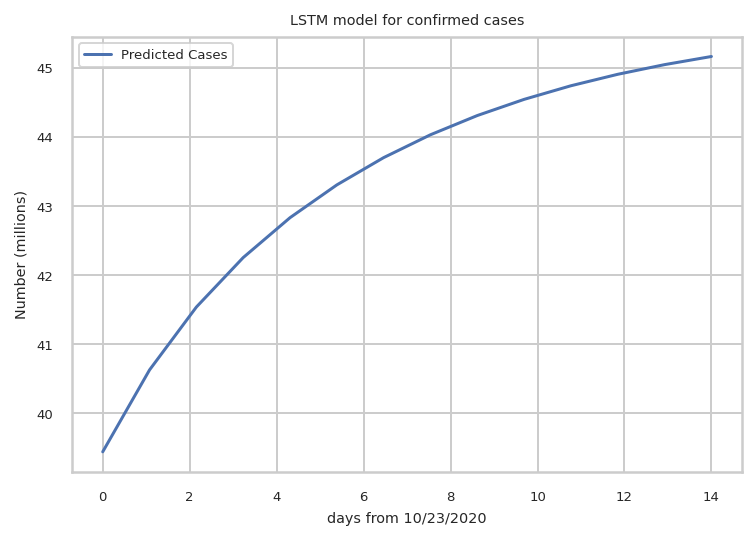

In [ ]:
confirmed_validation_predicted_cases, confirmed_predicted_cases = build_lstm(total_confirmed, name="confirmed")


Building LSTM model for deaths group.
Epoch 0 train loss: 0.2898009121417999 test loss: 1.1807317733764648
Epoch 20 train loss: 0.20780491828918457 test loss: 0.9587729573249817
Epoch 40 train loss: 0.11674052476882935 test loss: 0.5963932275772095
Epoch 60 train loss: 0.10371197015047073 test loss: 0.4211171269416809
Epoch 80 train loss: 0.10308624804019928 test loss: 0.40909621119499207
Epoch 100 train loss: 0.10186614096164703 test loss: 0.41078346967697144
Epoch 120 train loss: 0.09704245626926422 test loss: 0.37838035821914673
Epoch 140 train loss: 0.09250519424676895 test loss: 0.33427172899246216
Epoch 160 train loss: 0.02308560721576214 test loss: 0.02685713768005371
Epoch 180 train loss: 0.00749007984995842 test loss: 0.030035166069865227


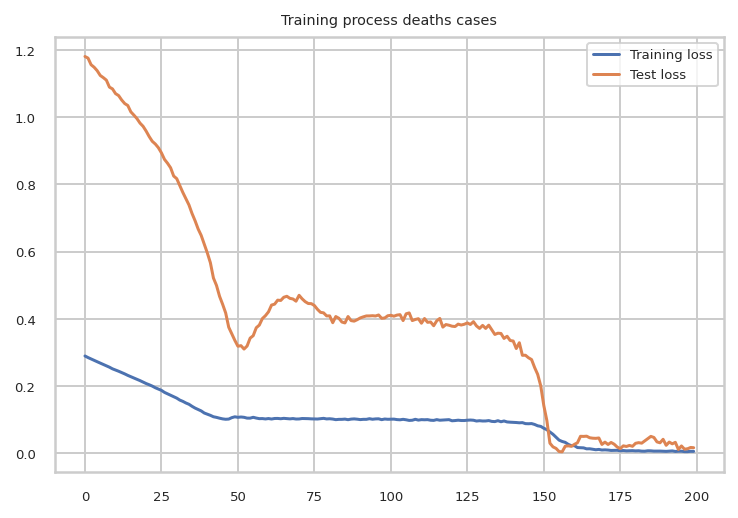

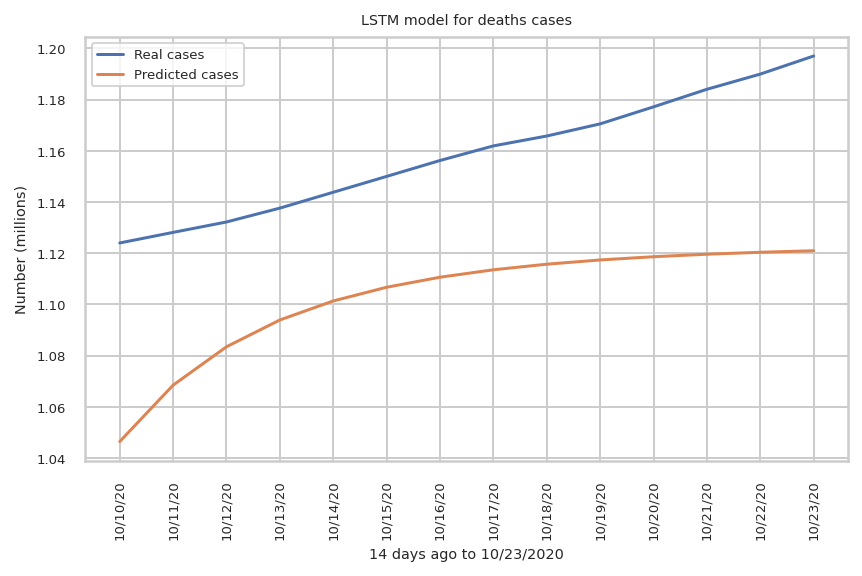

Epoch 0 train loss: 0.2032070904970169
Epoch 20 train loss: 0.14501747488975525
Epoch 40 train loss: 0.10328875482082367
Epoch 60 train loss: 0.10316152125597
Epoch 80 train loss: 0.10172288119792938
Epoch 100 train loss: 0.10191337764263153
Epoch 120 train loss: 0.09907007217407227
Epoch 140 train loss: 0.06215779855847359
Epoch 160 train loss: 0.010629799216985703
Epoch 180 train loss: 0.005982604809105396


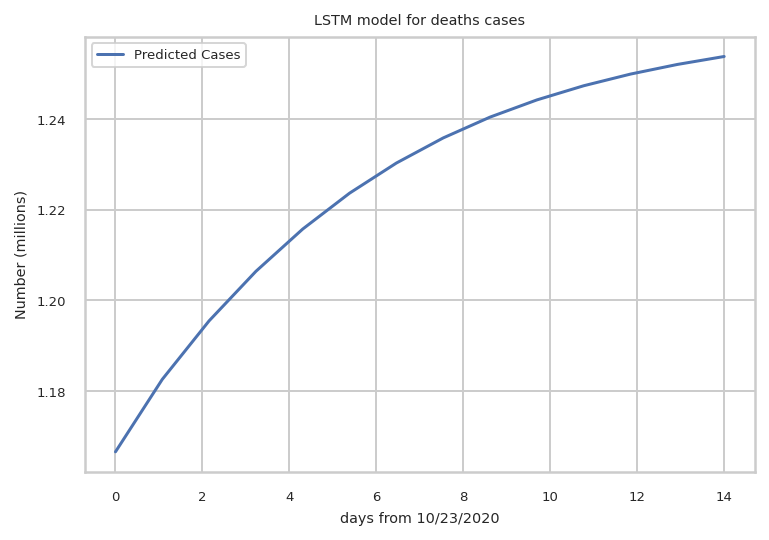

In [ ]:
death_validation_predicted_cases, death_predicted_cases = build_lstm(total_death, name="deaths")


Building LSTM model for recovered group.
Epoch 0 train loss: 0.1875937283039093 test loss: 1.2928861379623413
Epoch 20 train loss: 0.12761090695858002 test loss: 1.0428745746612549
Epoch 40 train loss: 0.08722801506519318 test loss: 0.6586624383926392
Epoch 60 train loss: 0.08516313135623932 test loss: 0.6721397638320923
Epoch 80 train loss: 0.0837574154138565 test loss: 0.5835795402526855
Epoch 100 train loss: 0.07547267526388168 test loss: 0.48517492413520813
Epoch 120 train loss: 0.007922392338514328 test loss: 0.032777074724435806
Epoch 140 train loss: 0.003691281657665968 test loss: 0.05341719090938568
Epoch 160 train loss: 0.0023421563673764467 test loss: 0.037867471575737
Epoch 180 train loss: 0.002087862230837345 test loss: 0.01494615152478218


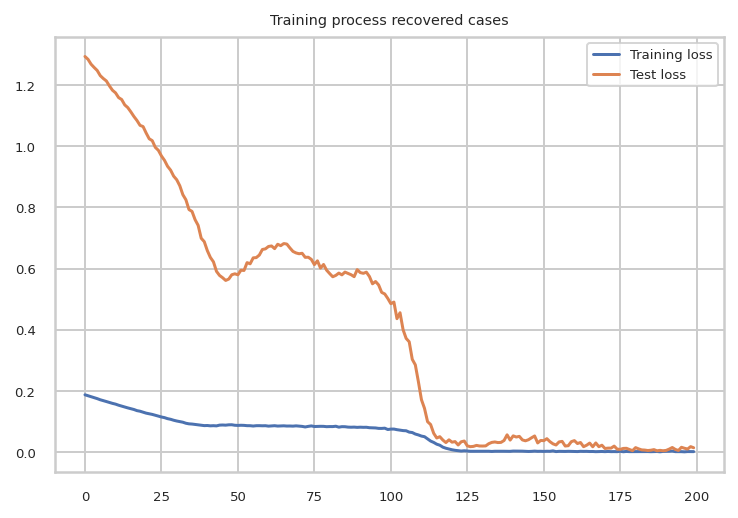

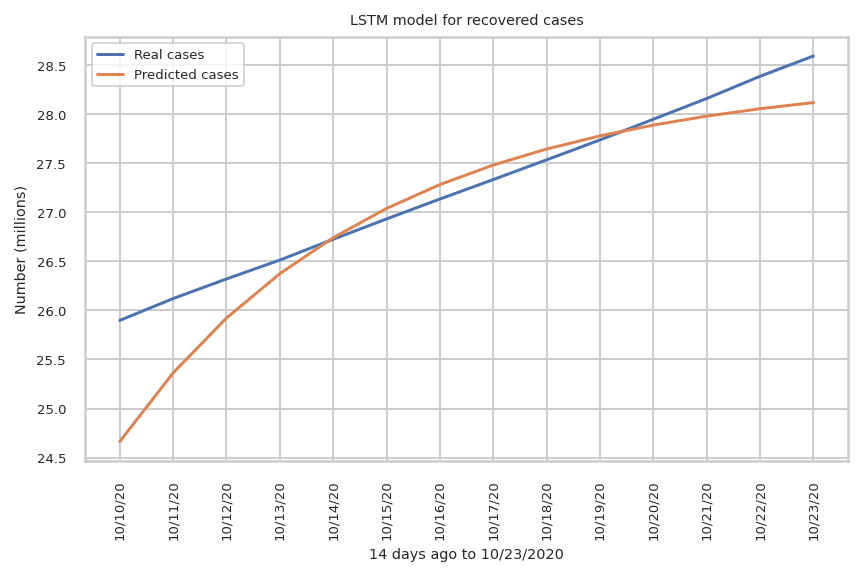

Epoch 0 train loss: 0.12229099869728088
Epoch 20 train loss: 0.09720729291439056
Epoch 40 train loss: 0.08840180188417435
Epoch 60 train loss: 0.08655969798564911
Epoch 80 train loss: 0.08468659222126007
Epoch 100 train loss: 0.06608960777521133
Epoch 120 train loss: 0.006262772250920534
Epoch 140 train loss: 0.0034109335392713547
Epoch 160 train loss: 0.002300573280081153
Epoch 180 train loss: 0.0021304143592715263


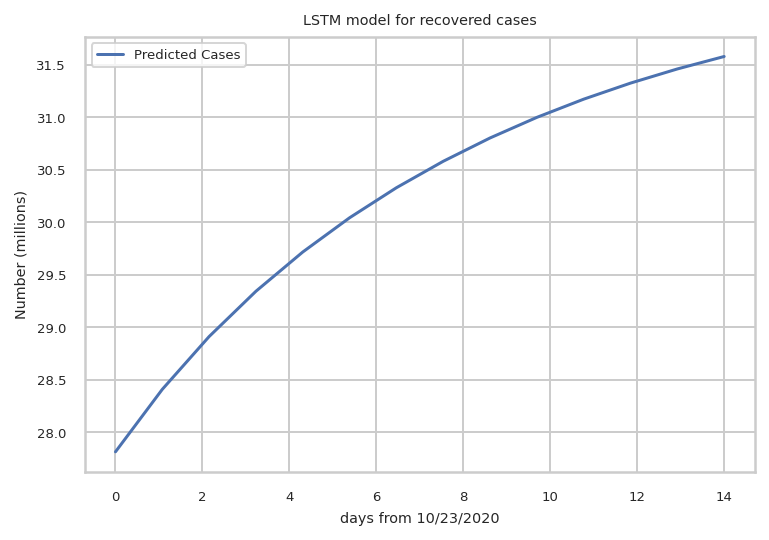

In [ ]:
recovered_validation_predicted_cases, recovered_predicted_cases = build_lstm(total_recovered, name="recovered")


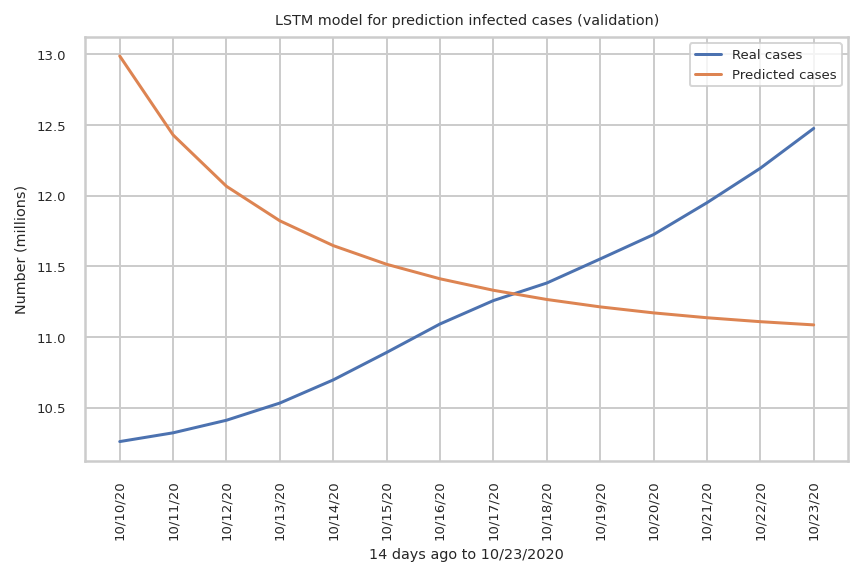

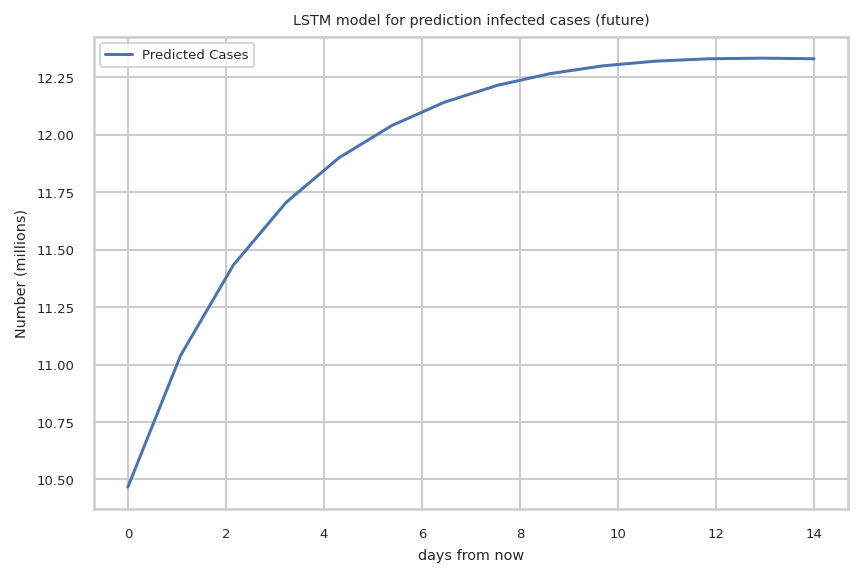

In [ ]:
lstm(time_series_data=[total_confirmed, total_death, total_recovered],
     validation_predicted_cases=[confirmed_validation_predicted_cases, death_validation_predicted_cases, recovered_validation_predicted_cases],
     predicted_cases=[confirmed_predicted_cases, death_predicted_cases, recovered_predicted_cases])


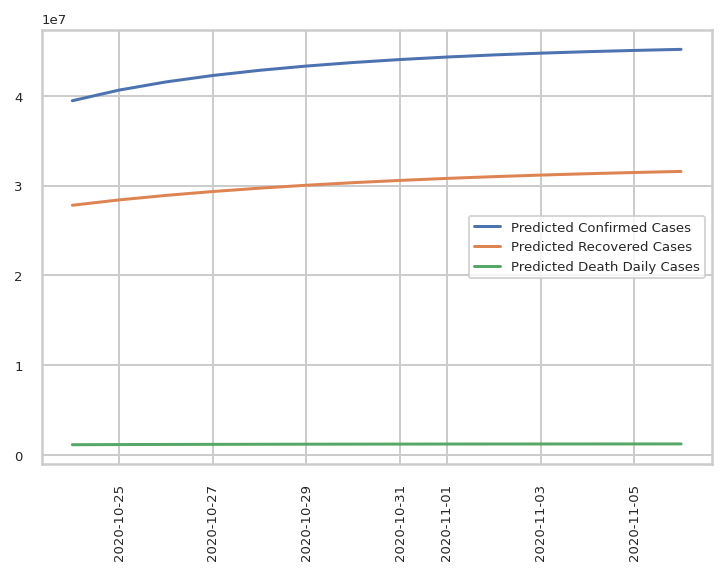

In [ ]:
predicted_index = pd.date_range(
  start=total_confirmed.index[-1],
  periods=15,
  closed='right'
)

confirmed_predicted_cases = pd.Series(
  data=confirmed_predicted_cases,
  index=predicted_index
)
recovered_predicted_cases = pd.Series(
  data=recovered_predicted_cases,
  index=predicted_index
)
death_predicted_cases = pd.Series(
  data=death_predicted_cases,
  index=predicted_index
)

plt.plot(confirmed_predicted_cases, label='Predicted Confirmed Cases')
plt.plot(recovered_predicted_cases, label='Predicted Recovered Cases')
plt.plot(death_predicted_cases, label='Predicted Death Daily Cases')
plt.xticks(rotation=90)
plt.legend();

In [ ]:
def Cal_R0(confirmed, recovered):
  I = confirmed - recovered
  n = len(confirmed)
  E = np.zeros(n)
  S = np.zeros(n)
  R = recovered #cases
  R = R.astype(float)
  gamma = np.zeros(n-1,dtype = float)
  beta = np.zeros(n-1,dtype = float)
  sigma =   0.15579710144927536
  for i in range(0, n-1):
      gamma[i] = (R[i+1] - R[i]) / I[i]
      E[i]     = (I[i+1] - I[i] +gamma[i]*I[i])/sigma
      S[i]     = population - E[i] - I[i] - R[i]
  for i in range(0,n-2):
      beta[i] = ((E[i+1] - E[i] + sigma*E[i])*population) / (I[i]*S[i])
  for i in range(0,n-2):
      R[i] = beta[i] / gamma[i] # r0
  return R,beta, gamma

In [ ]:
r0_predict,beta_predict,gamma_predict = Cal_R0(confirmed_validation_predicted_cases, recovered_validation_predicted_cases+death_validation_predicted_cases) # predict 
r0_real,beta_real,gamma_real = Cal_R0(total_confirmed,total_death + total_recovered)

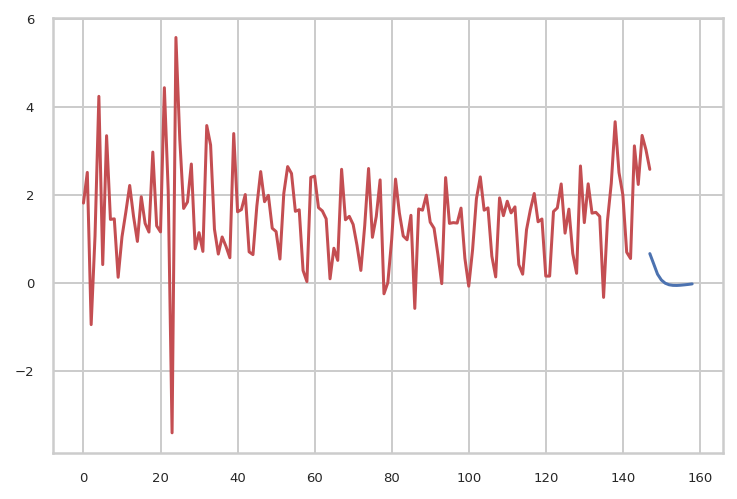

In [ ]:
plt.plot(np.arange(0,148,1),r0_real[-150:-2],'r')
plt.plot(np.arange(147,159,1),r0_predict[:-2],'b')

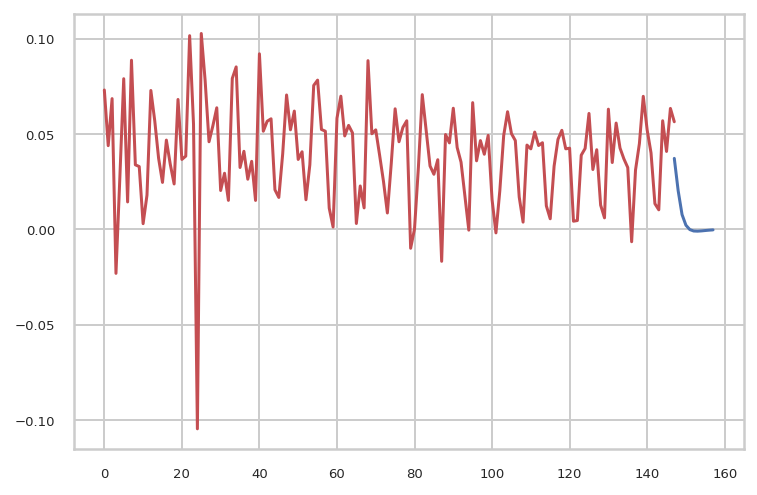

In [ ]:
plt.plot(np.arange(0,148,1),beta_real[-150:-2],'r')
plt.plot(np.arange(147,158,1),beta_predict[:-2],'b')

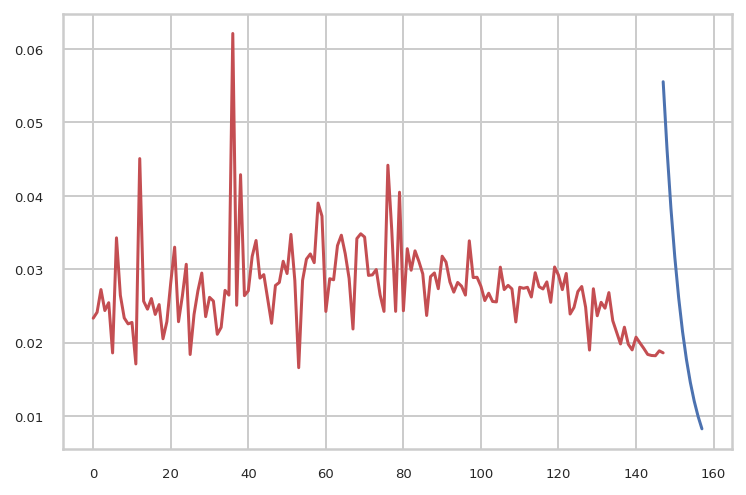

In [ ]:
plt.plot(np.arange(0,148,1),gamma_real[-150:-2],'r')
plt.plot(np.arange(147,158,1),gamma_predict[:-2],'b')